# Machine Learning: Intermediate report

*Write your name and your student ID below.*

+ Your name (Your ID)

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following three problems, and submit the notebook file (`.ipynb`) on OCW. *We do not accept a report in other formats (e.g., Word, PDF, HTML)*. Write a code at the specified cell in the notebook. One can add more cells if necessary.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearningclass/blob/master/mlp_binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearningclass/blob/master/mnist.ipynb)

*Please accept that your report may be shared among students who take this course.*

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the performance of the model on the test set in the following evaluation measures:

+ Accuracy
+ Precision, recall, and F1 scores on each category (digit)
+ Macro-averaged precision, recall, and F1 scores (i.e., the averages of the above measures for all categories)

One can use the same code shown in the lecture. Write a code here and show the output.

## Preparing the MNIST dataset

In [0]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

In [0]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


In [0]:
!pip install livelossplot

In [0]:
!pip install torch torchvision

In [0]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

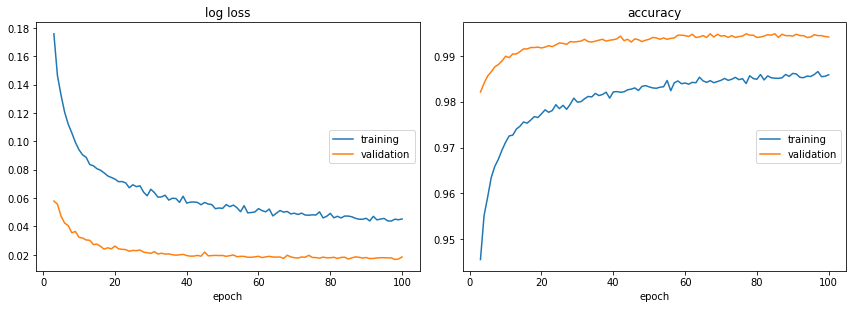

log loss:
training   (min:    0.044, max:    0.699, cur:    0.045)
validation (min:    0.017, max:    0.125, cur:    0.018)

accuracy:
training   (min:    0.765, max:    0.987, cur:    0.986)
validation (min:    0.963, max:    0.995, cur:    0.994)
Accuracy: 0.9941 (test), 0.9859 (train)


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

In [0]:
!pip install scikit-learn

In [0]:
model = model.eval()

In [0]:
from sklearn.metrics import classification_report

y_pred  = []
y_true = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        output = model(x)
    y_pred += [int(l.argmax()) for l in output]
    y_true += [int(l) for l in y]

print(classification_report(y_true, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99189   0.99898   0.99542       980
           1    0.99387   0.99912   0.99649      1135
           2    0.99805   0.99419   0.99612      1032
           3    0.99800   0.99010   0.99404      1010
           4    0.99592   0.99389   0.99490       982
           5    0.98446   0.99439   0.98940       892
           6    0.99790   0.99269   0.99529       958
           7    0.99223   0.99319   0.99271      1028
           8    0.99691   0.99384   0.99537       974
           9    0.99107   0.99009   0.99058      1009

    accuracy                        0.99410     10000
   macro avg    0.99403   0.99405   0.99403     10000
weighted avg    0.99412   0.99410   0.99410     10000



## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/izumo27/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[ 979,    0,    0,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1134,    0,    0,    0,    1,    0,    0,    0,    0],
       [   1,    1, 1026,    0,    0,    0,    0,    3,    1,    0],
       [   0,    1,    1, 1000,    0,    6,    0,    0,    2,    0],
       [   0,    0,    0,    0,  976,    0,    1,    0,    0,    5],
       [   1,    0,    0,    2,    0,  887,    1,    1,    0,    0],
       [   3,    2,    0,    0,    1,    1,  951,    0,    0,    0],
       [   0,    3,    1,    0,    0,    1,    0, 1021,    0,    2],
       [   3,    0,    0,    0,    0,    1,    0,    0,  968,    2],
       [   0,    0,    0,    0,    3,    4,    0,    3,    0,  999]])

## 3. Top-3 easy and confusing examples

Show the top three easy and three confusing, respectively, images where the model recognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n = \hat{y}_n$ (easy examples) $y_n \neq \hat{y}_n$ (confusing examples).

Please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$. This is an example of an output for an image (you need this kind of outputs for top-three easy and top-three confusing images).

![example](https://github.com/izumo27/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

In [0]:
import torch.nn.functional as F

test_loader = DataLoader(test_set, batch_size=1)

predictions = []

for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        prediction = F.softmax(model(x), dim=1)
        predictions.append((i, prediction[0][y][0].cpu().numpy(), prediction.argmax(), prediction.max()))
        
predictions.sort(key=lambda x:x[1])

#### Top-3 easy

True digit: 5 (1.0000); prediction: 5 (1.0000)


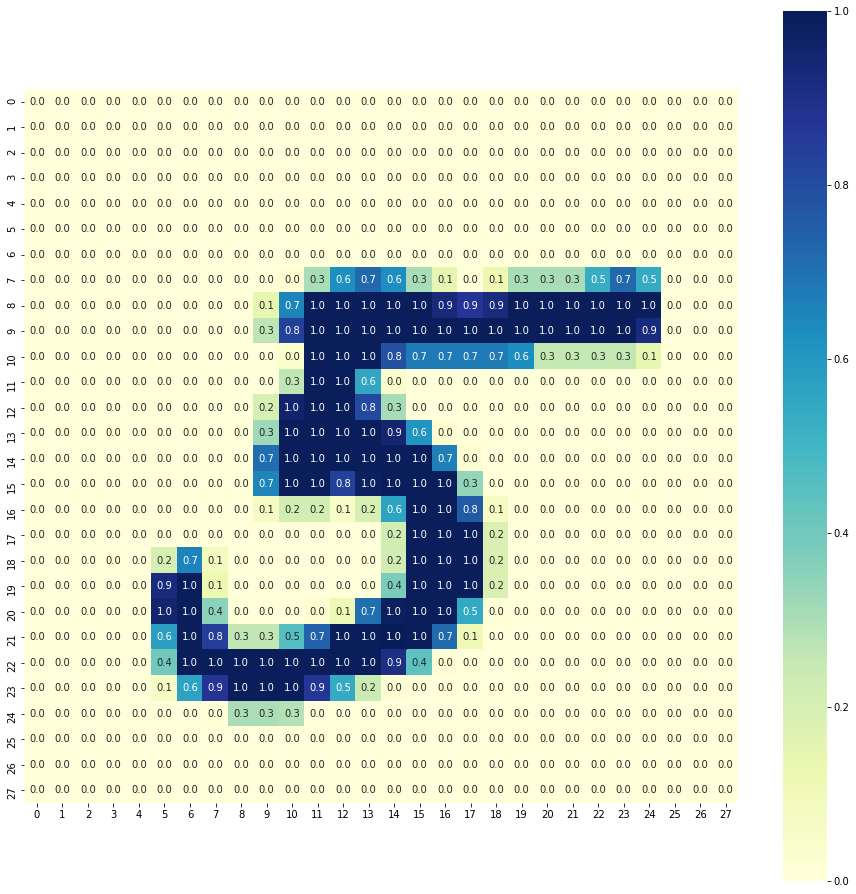

True digit: 6 (1.0000); prediction: 6 (1.0000)


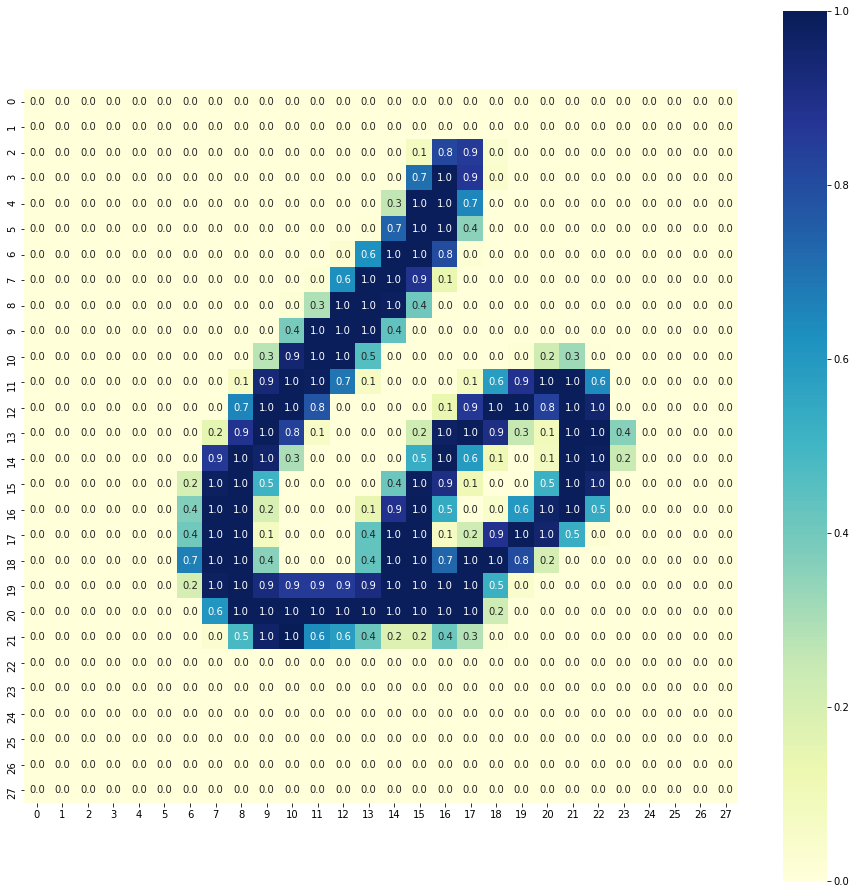

True digit: 8 (1.0000); prediction: 8 (1.0000)


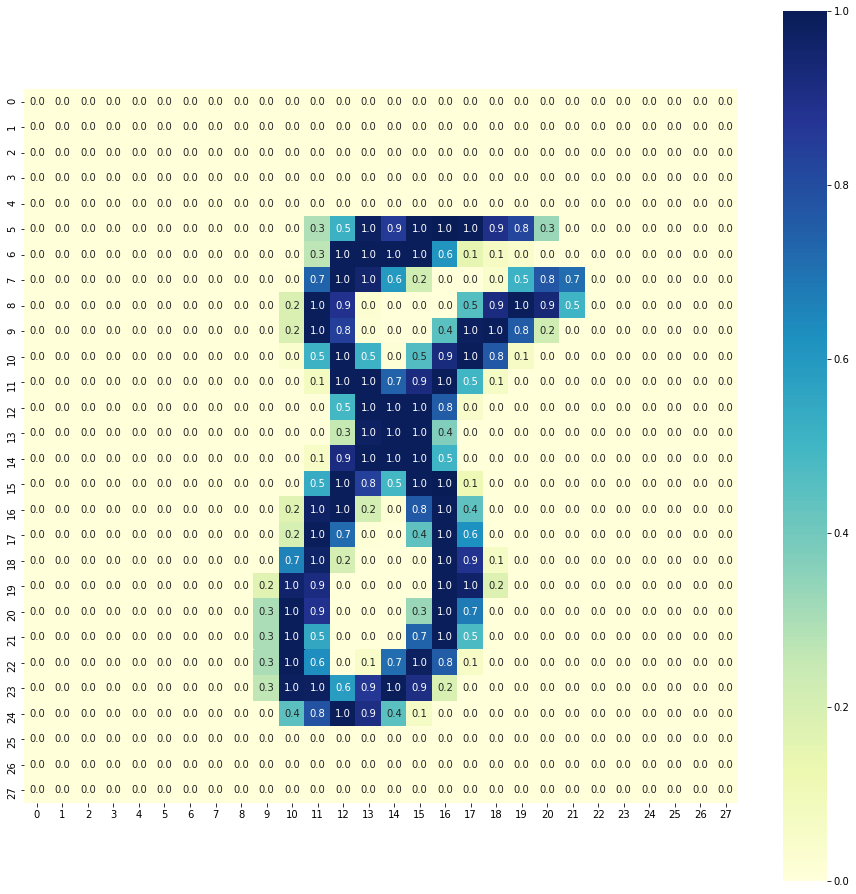

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

n = 10000

for i in range(3):
  tmp = predictions[n-1-i]
  image = data['test_x'][tmp[0]]
  label = data['test_y'][tmp[0]]

  print('True digit: {0} ({1:.4f}); prediction: {2} ({3:.4f})'.format(label, tmp[1], tmp[2], tmp[3]))
  f, ax = plt.subplots(figsize=(16, 16))
  sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
  plt.show()

#### Top-3 confusing

True digit: 6 (0.0011); prediction: 5 (0.9848)


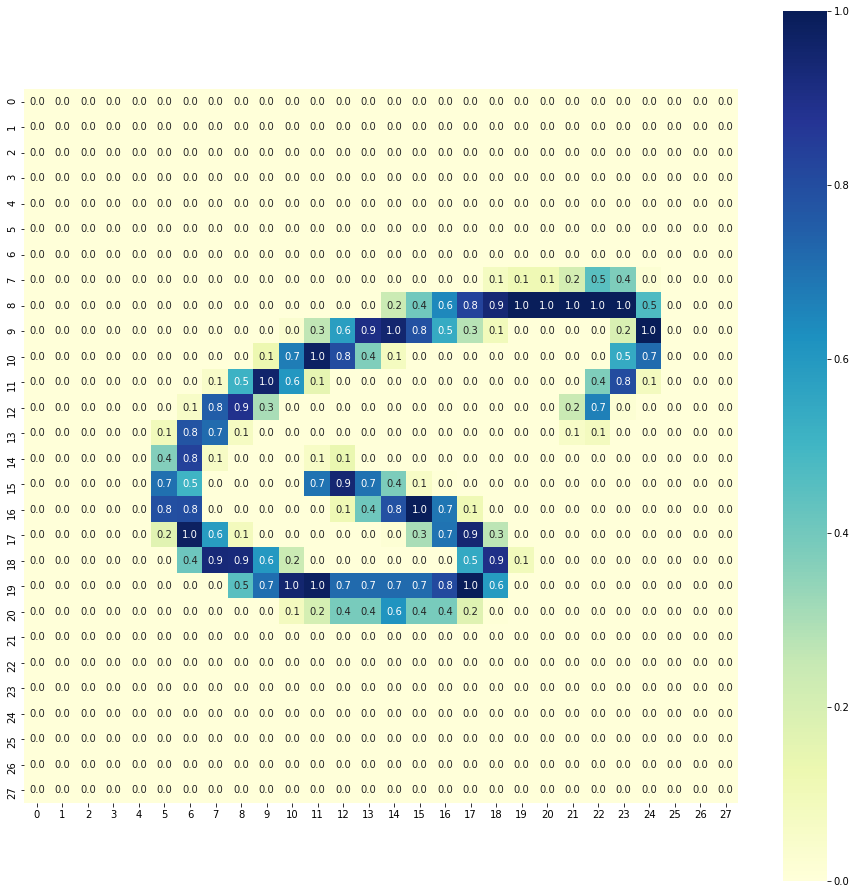

True digit: 0 (0.0035); prediction: 7 (0.9918)


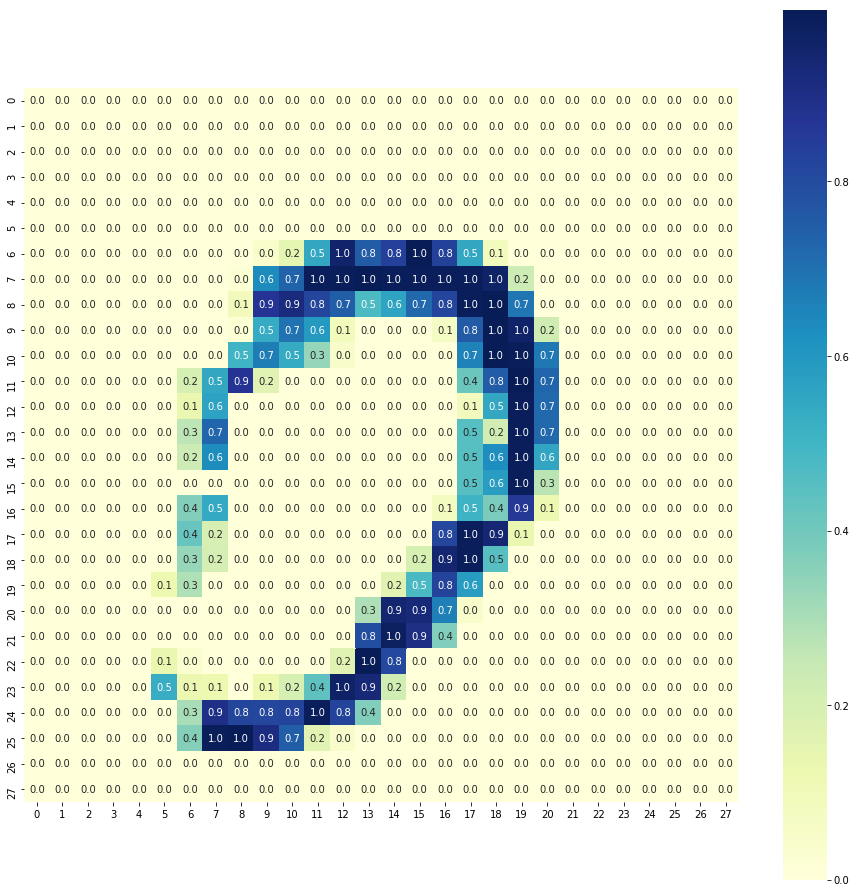

True digit: 6 (0.0037); prediction: 1 (0.9942)


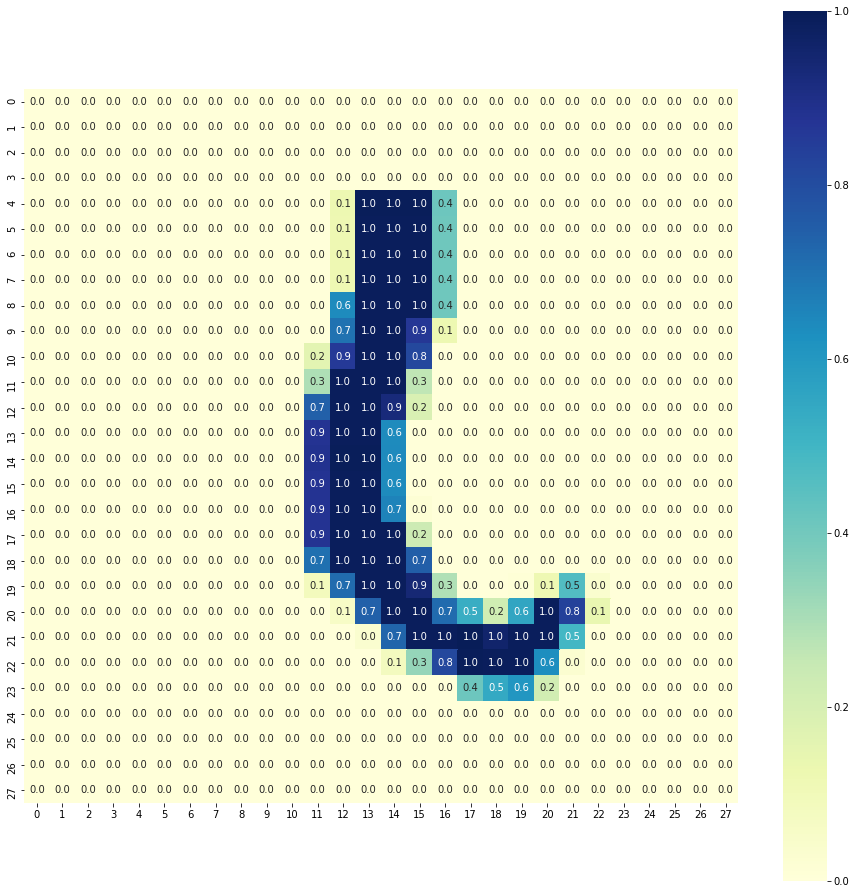

In [0]:
for i in range(3):
  tmp = predictions[i]
  image = data['test_x'][tmp[0]]
  label = data['test_y'][tmp[0]]

  print('True digit: {0} ({1:.4f}); prediction: {2} ({3:.4f})'.format(label, tmp[1], tmp[2], tmp[3]))
  f, ax = plt.subplots(figsize=(16, 16))
  sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
  plt.show()